<a href="https://colab.research.google.com/github/MalenaGlez/TFG-CNN-Resonancias/blob/main/Modelo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importaciones
import os
import cv2
import numpy as np
from sklearn.preprocessing import label_binarize

import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras import metrics

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shutil

Fijamos semilla para que los resultados sean reproducibles:

In [ ]:
semilla = 27

np.random.seed(semilla)
random.seed(semilla)
tf.random.set_seed(semilla)
os.environ['PYTHONHASHSEED'] = str(semilla)

# Hacer deterministas las operaciones
tf.keras.utils.set_random_seed(semilla)
tf.config.experimental.enable_op_determinism()

In [ ]:
#Rutas de los datos ya procesados:
shutil.copytree('/content/drive/My Drive/processed_data2', '/content/processed_data2')

train_dir = '/content/processed_data2/train'
test_dir = '/content/processed_data2/test'
val_dir = '/content/processed_data2/val'


En este modelo, en vez de trabajar con las imágenes como arrays, se emplean generadores para poder realizar el aumento de datos mediante transformaciones.


In [ ]:
# Transformaciones a las imágenes del conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# En los conjutos test y val no aplicamos las tranformaciones, solo escalamos
# a 0 y 1, ya que queremos evaluar el modelo sobre datos reales.
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Creación generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),       # Redimensión de las imágenes a 224x224 pixels
    batch_size=32,                # Tamaño del batch
    class_mode='sparse',     # Categorías al ser 3 clases (one-hot encoding)
    color_mode='grayscale',
    shuffle=True,                 # para que el modelo vea las imágenes en
                                  # distinto orden en cada época
    seed=semilla
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    color_mode='grayscale',
    shuffle=False,              # La evaluación siempre sobre el mismo orden
    seed=semilla
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    color_mode='grayscale',
    shuffle=False,
    seed=semilla
)

Found 5322 images belonging to 3 classes.
Found 1137 images belonging to 3 classes.
Found 1141 images belonging to 3 classes.


In [ ]:
print("Orden de clases en el generador:", train_generator.class_indices)

Orden de clases en el generador: {'alzheimers_dataset': 0, 'normal': 1, 'parkinsons_dataset': 2}


# Configuración del entrenamiento

1.   Creamos el modelo de red neuronal convolucional, compuesto por:
      *   Cuatro bloques convolucionales.
      *   Una capa densa y otra capa de salida.

2.   Compilamos el modelo:
      *   Como optimizador para los pesos usamos 'adam'.
      *   La función de pérdida es 'sparse_categorical_crossentropy' porque el tipo de etiquetas son enteros (0, 1 o 2).

In [ ]:
# Definición del modelo CNN
modelo = Sequential([
    Input(shape=(224, 224, 1)),  # imagenes en escala de grises

    Conv2D(32, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),


    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# El modelo optimiza la función de pérdida loss
modelo.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy',
             metrics.Recall(class_id = 0, name = 'recall_alzheimer'),  # Recall para Alzheimer (clase 0)
             metrics.Recall(class_id = 2, name = 'recall_parkinson'),  # Recall para Parkinson (clase 2)
             ]
)

3.   Asignamos a cada clase unos pesos para penalizar más los errores en las categorías que clasifica menos bien.

4.   Parada temprana mediante EarlyStopping:
      *   Detiene el entrenamiento si durante 5 épocas no hay mejora en la périda de validación.

In [ ]:
class_weight = {
    0: 2.5,  # Alzheimer
    1: 1.3,  # Normal
    2: 1.0   # Parkinson
}

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,         # Número de épocas sin mejora antes de detener
   restore_best_weights = True  # Restaura los mejores pesos encontrados
)

# Entrenamiento del modelo
Entrenamos el modelo anterior durante 30 épocas y con un tamaño de batch de 32.

In [ ]:
print("Comenzanzo entrenamiento")
historial = modelo.fit(
    train_generator,
    epochs = 30,
    validation_data = validation_generator,
    class_weight = class_weight,
    callbacks = [early_stopping]
)
print("Entrenamiento terminado")

Comenzanzo entrenamiento


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - accuracy: 0.5794 - loss: 1.1520 - recall_alzheimer: 0.4647 - recall_parkinson: 0.2389 - val_accuracy: 0.7134 - val_loss: 0.5271 - val_recall_alzheimer: 0.3791 - val_recall_parkinson: 0.4729
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.7255 - loss: 0.7957 - recall_alzheimer: 0.4849 - recall_parkinson: 0.3037 - val_accuracy: 0.7879 - val_loss: 0.4328 - val_recall_alzheimer: 0.2048 - val_recall_parkinson: 0.4373
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.7681 - loss: 0.7241 - recall_alzheimer: 0.4690 - recall_parkinson: 0.3010 - val_accuracy: 0.7897 - val_loss: 0.4071 - val_recall_alzheimer: 0.2285 - val_recall_parkinson: 0.4452
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.8031 - loss: 0.6672 - recall_alzheimer: 0.4431 - recall_parkinson: 0.3206 - val_accuracy: 0.8054 - val_loss: 0.4148 - val_recall_alzheimer: 0.2312 - val_recall_parkinson: 0.4425
Epoch 5/30
1

# Evaluación del modelo
Evaluamos el modelo entrenado en un conjunto de datos que no ha sido visto durante el entrenamiento, el conjunto test.

In [ ]:
evaluation = modelo.evaluate(test_generator)
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')
print(f'Pérdida: {evaluation[0]:.2f}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8723 - loss: 0.3209 - recall_alzheimer: 0.1400 - recall_parkinson: 0.1125
Test Accuracy: 86.72%
Pérdida: 0.29


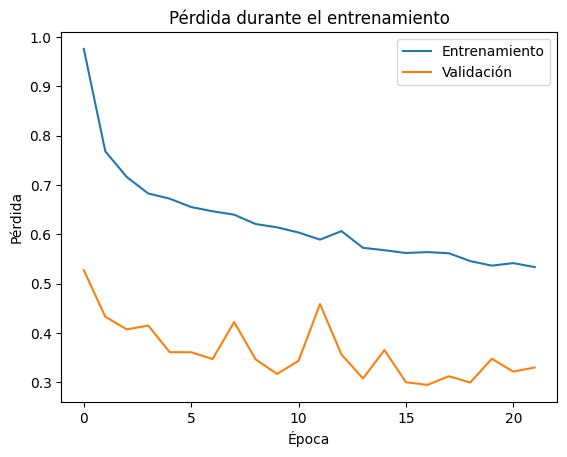

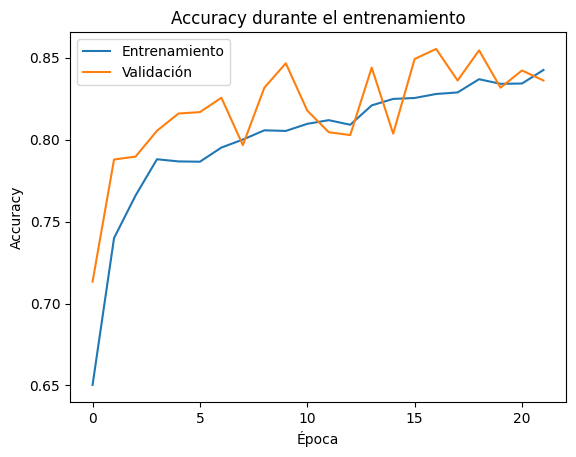

In [ ]:
# Pérdida (loss)
plt.plot(historial.history['loss'], label='Entrenamiento')
plt.plot(historial.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Precisión global (accuracy)
plt.plot(historial.history['accuracy'], label='Entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Métricas
1.   Calculamos las probabilidades de que cada imagen del conjunto test pertecezca a cada clase (y_pred_probs).
2.   Después se toma para cada valor el argumento máximo, conviertiéndose en la clase predicha (y_pred).
3.   Por último, calculamos la matriz de confusión comparando lo que se ha obtenido al predecir (y_pred) y lo que realmente es (y_true).


In [ ]:
# Obtener predicciones del modelo sobre el conjunto de test
y_pred_probs = modelo.predict(test_generator)      # Probabilidades
y_pred = np.argmax(y_pred_probs, axis=1)           # Clase predicha

# Obtener las verdaderas etiquetas
y_true = test_generator.classes

# Matriz de confusión
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print(cm)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Confusion Matrix
[[336  39   0]
 [112 292   0]
 [  0   0 358]]


In [ ]:
# Informe de clasificación
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

                    precision    recall  f1-score   support

alzheimers_dataset       0.75      0.90      0.82       375
            normal       0.88      0.72      0.79       404
parkinsons_dataset       1.00      1.00      1.00       358

          accuracy                           0.87      1137
         macro avg       0.88      0.87      0.87      1137
      weighted avg       0.88      0.87      0.87      1137



In [ ]:
VP1=cm[0,0]
VP2=cm[1,1]
VP3=cm[2,2]
VP=[VP1,VP2,VP3]

#Total reales por clase (suma filas)
total_real = np.sum(cm, axis=1)

# Total predichos por clase (suma columnas)
total_pred = np.sum(cm, axis=0)
suma_total = np.sum(cm)

#Métricas
Accuracy = (VP1+VP2+VP3)/suma_total
Tasa_error = 1-Accuracy
precision = VP / total_pred
recall = VP / total_real
f1 = 2 * (precision * recall) / (precision + recall)

In [ ]:
print(f"Accuracy: {Accuracy:.3f}")
print(f"Tasa de error: {Tasa_error:.3f}")
for i in range(len(VP)):
    print(f"Clase {i}:")
    print(f"  Precisión: {precision[i]:.3f}")
    print(f"  Recall:    {recall[i]:.3f}")
    print(f"  F1-score:  {f1[i]:.3f}")


Accuracy: 0.867
Tasa de error: 0.133
Clase 0:
  Precisión: 0.750
  Recall:    0.896
  F1-score:  0.817
Clase 1:
  Precisión: 0.882
  Recall:    0.723
  F1-score:  0.795
Clase 2:
  Precisión: 1.000
  Recall:    1.000
  F1-score:  1.000
